# Predictions

## Packages and Assets

In [41]:
import keras.models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import seaborn as sns
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from keras.preprocessing.text import Tokenizer, tokenizer_from_json
from keras.utils import pad_sequences


In [42]:
model = keras.models.load_model('../../assets/lstm_model')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 11, 300)           2406300   
                                                                 
 bidirectional_2 (Bidirectio  (None, 11, 128)          186880    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 2,696,223
Trainable params: 289,923
Non-

In [43]:
with open('../../assets/word_index.json', 'r') as f:
    word_index = json.load(f)
    word_index = dict(word_index)

In [44]:
# Load the tokenizer from the file
with open('../../assets/tokenizer.json', 'r', encoding='utf-8') as f:
    tokenizer_json = f.read()
    tokenizer = tokenizer_from_json(tokenizer_json)

## Functions

In [45]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import pandas as pd
import re
import string
import nltk

In [46]:
def transformDocument(df, column_name, language):
    stop_words = usingStopwords(language)
    # 1. Aplicar preprocessamento nos títulos e textos completos
    if language == 'pt':
        # Substituir símbolos importantes
        df[column_name] = df[column_name].map(lambda s: s.replace('-feira', ''))
        df[column_name] = df[column_name].map(lambda s: s.replace('+', 'mais '))
        df[column_name] = df[column_name].map(lambda s: s.replace('-', 'menos '))
        df[column_name] = df[column_name].map(lambda s: s.replace('%', ' por cento'))
        df[column_name] = df[column_name].map(lambda s: removeStopwords(s, stop_words))

    elif language == 'en':
        df[column_name] = df[column_name].map(lambda s: s.replace('-', 'less'))
        df[column_name] = df[column_name].map(lambda s: s.replace('+', 'plus '))
        df[column_name] = df[column_name].map(lambda s: s.replace('%', ' percent'))
        df[column_name] = df[column_name].map(lambda s: removeStopwords(s, stop_words))

    else:
        pass

    df[column_name] = df[column_name].map(lambda s: s.replace('R$', ''))
    df[column_name] = df[column_name].map(lambda s: s.replace('U$', ''))
    df[column_name] = df[column_name].map(lambda s: s.replace('US$', ''))
    df[column_name] = df[column_name].map(lambda s: s.replace('S&P 500', 'spx'))

    # Transformar em String e Letras Minúsculas nas Mensagens
    df[column_name] = df[column_name].map(lambda s:
                                              normalizarString(s))

    # Remover Pontuações
    # Remover Pontuações
    df[column_name] = df[column_name].map(lambda s: s.translate(str.maketrans('', '', string.punctuation)))

    # Remover Emojis
    df[column_name] = df[column_name].map(lambda s: removeEmojis(s))

    # Quebras de Linha desnecessárias
    df[column_name] = df[column_name].map(lambda s: s.replace('\n', ' '))

    # Remover aspas duplas
    df[column_name] = df[column_name].map(lambda s: s.replace('\"', ''))
    df[column_name] = df[column_name].map(lambda s: s.replace('“', ''))
    df[column_name] = df[column_name].map(lambda s: s.replace('”', ''))

    # Remover valores
    df[column_name] = df[column_name].map(lambda s: removeValores(s))

    # Espaços desnecessários
    df[column_name] = df[column_name].map(lambda s: s.strip())
    return df

def removeEmojis(sentence):
    "Remoção de Emojis nas mensagens de texto."

    # Padrões dos Emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u'\U00010000-\U0010ffff'
                               u"\u200d"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\u3030"
                               u"\ufe0f"
                               "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r'', sentence)

def removeValores(sentence):
    new_sentece = ''

    for token in sentence.split():
        if token.isdigit():
            token = '<NUM>'
        new_sentece += ' {}'.format(token)

    return new_sentece

def usingStopwords(language):
    stop_words = []

    nltk.download('stopwords')

    if language == 'pt':
        stop_words = nltk.corpus.stopwords.words('portuguese')
    elif language == 'en':
        stop_words = nltk.corpus.stopwords.words('english')

    return stop_words

def removeStopwords(text, stop_words):
    tokens = []
    for word in text.split():
        if word not in stop_words:
            tokens.append(word)

    text = ' '.join(tokens)
    return text

def normalizarString(text):
    """
    Função para retirar acentuações e converter para minúscula
    :param text:
    :return text_normalizado
    """
    import unicodedata

    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    return str(text.lower())

## Preparing test data

In [47]:
train_preprocessed = pd.read_csv('../../assets/data/train/preprocessed.csv')
X_train = train_preprocessed.title

In [48]:
test_raw = pd.read_csv('../../assets/data/test/raw.csv')
test_raw

,title,tags,link,label
0,Gasolina cai ao menor valor em quase 3 anos no...,"['Cepea', 'Combustíveis', 'Coronavírus', 'Econ...",https://www.moneytimes.com.br/gasolina-cai-ao-...,0
1,"Radar: Petrobras (PETR4) atualiza dividendos, ...","['Petrobras (PETR4)', 'CVC (CVCB3)', 'Embraer ...",https://www.suno.com.br/noticias/radar-petrobr...,0
2,Justiça mineira bloqueia R$ 5 bilhões da Vale,"['Empresas', 'Mineração', 'Vale']",https://www.moneytimes.com.br/justica-mineira-...,1
3,Bolsonaro não quer e não pode intervir em preç...,"['Combustíveis', 'Diesel', 'Economia', 'Jair B...",https://www.moneytimes.com.br/bolsonaro-nao-qu...,0
4,BofA eleva preço-alvo da Petrobras (PETR4) ao ...,"['Bank Of America (BOAC34)', 'PETR3', 'Petrobr...",https://www.suno.com.br/noticias/bofa-eleva-pr...,0
...,...,...,...,...
1191,"Etanol: como no boi, mesmo com consumo fraco p...","['Açúcar', 'Agro Times', 'Cepea', 'Etanol', 'G...",https://www.moneytimes.com.br/etanol-como-no-b...,0
1192,Petrobras reporta emissão de gases em refinari...,"['Empresas', 'Petrobras']",https://www.moneytimes.com.br/petrobras-report...,0
1193,Petrobras não precisará republicar balanços,"['CVM', 'Empresas', 'Petrobras']",https://www.moneytimes.com.br/petrobras-nao-pr...,0
1194,Petrobras deve receber ofertas por refinaria d...,"['Bahia', 'Emirados Árabes Unidos', 'Empresas'...",https://www.moneytimes.com.br/petrobras-deve-r...,0


In [60]:
test_preprocessed = transformDocument(test_raw, 'title', 'pt')

X_test = test_preprocessed.title
y_test = test_preprocessed.to_numpy()[:, -1]

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=11, padding='post', truncating='post')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guimi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [50]:
test_padded

array([[  26,   54,  260, ...,    7,  775,  692],
       [  87,    3,    8, ...,  151,  514,  626],
       [ 110, 3122, 1544, ...,    0,    0,    0],
       ...,
       [   3, 5548,    1, ...,    0,    0,    0],
       [   3,   63,  714, ...,   20,  315,    0],
       [  97,  649, 6576, ...,    0,    0,    0]])

### Functions

In [51]:
def index2word(word_index):
    index_word = {}
    for key in word_index:
        index_word[word_index[key]] = key
    return index_word


def seq2text(seq, index_word):
    text = []
    for index in seq:
        text.append(index_word[index])
    return text

def show_confusion_matrix(cm):
        print("Confusion Matrix")
        plt.figure(figsize=(10, 7))

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'],
                    yticklabels=['Negative', 'Positive'])
        plt.xlabel('Predicted')
        plt.ylabel('Truth')
        plt.title('Confusion Matrix')
        plt.show()

In [52]:
index_word = index2word(word_index)

In [53]:
pred_prob = model.predict(test_padded)

38/38 [==============================] - 2s 8ms/step


In [54]:
# y_pred = [1 if p > 0.5 else 0 for p in pred_prob]


In [55]:
y_pred = np.argmax(pred_prob, axis=1)

In [58]:
y_test

array([0, 0, 1, ..., 0, 0, 0], dtype=object)

In [63]:
df_results = pd.DataFrame()
X_test = list(X_test)
y_test = list(y_test)
df_results['sequence'] = test_sequences
df_results['X_test'] = X_test
df_results['seq2text'] = df_results['sequence'].apply(lambda x: seq2text(x, index_word))
df_results['y_pred'] = y_pred
df_results['y_true'] = y_test
df_results

,sequence,X_test,seq2text,y_pred,y_true
0,"[26, 54, 260, 94, 146, 145, 20, 7, 775, 692]",gasolina cai menor valor quase anos brasil diz...,"[gasolina, cai, menor, valor, quase, anos, bra...",1,0
1,"[87, 3, 8, 292, 18, 373, 410, 656, 151, 514, 6...",radar petrobras petr4 atualiza dividendos prej...,"[radar, petrobras, petr4, atualiza, dividendos...",0,0
2,"[110, 3122, 1544, 30, 4]",justica mineira bloqueia bilhoes vale,"[justica, mineira, bloqueia, bilhoes, vale]",1,1
3,"[50, 106, 33, 2397, 47, 7, 1, 1]",bolsonaro quer pode intervir precos diz portam...,"[bolsonaro, quer, pode, intervir, precos, diz,...",2,0
4,"[484, 68, 181, 129, 3, 8, 1226, 791, 1695, 628...",bofa eleva precomenos alvo petrobras petr4 ver...,"[bofa, eleva, precomenos, alvo, petrobras, pet...",0,0
...,...,...,...,...,...
1191,"[96, 7897, 731, 3057, 28, 45, 1, 71, 258]",etanol boi consumo fraco preco sobe origem ofe...,"[etanol, boi, consumo, fraco, preco, sobe, <OO...",0,0
1192,"[3, 1, 391, 1, 177, 978, 124]",petrobras reporta emissao gases refinaria pasa...,"[petrobras, <OOV>, emissao, <OOV>, refinaria, ...",0,0
1193,"[3, 5548, 1, 481]",petrobras precisara republicar balancos,"[petrobras, precisara, <OOV>, balancos]",0,0
1194,"[3, 63, 714, 634, 177, 237, 322, 75, 20, 315]",petrobras deve receber ofertas refinaria bahia...,"[petrobras, deve, receber, ofertas, refinaria,...",0,0


### Metrics

In [68]:
# accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
# precision = precision_score(average='macro', y_true=y_test, y_pred=y_pred)
# recall = recall_score(average='macro', y_true=y_test, y_pred=y_pred)
# f1 = f1_score(average='macro', y_true=y_test, y_pred=y_pred)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

              precision    recall  f1-score   support

           0       0.74      0.79      0.76       596
           1       0.68      0.69      0.68       388
           2       0.56      0.45      0.50       212

    accuracy                           0.69      1196
   macro avg       0.66      0.64      0.65      1196
weighted avg       0.69      0.69      0.69      1196

Confusion Matrix


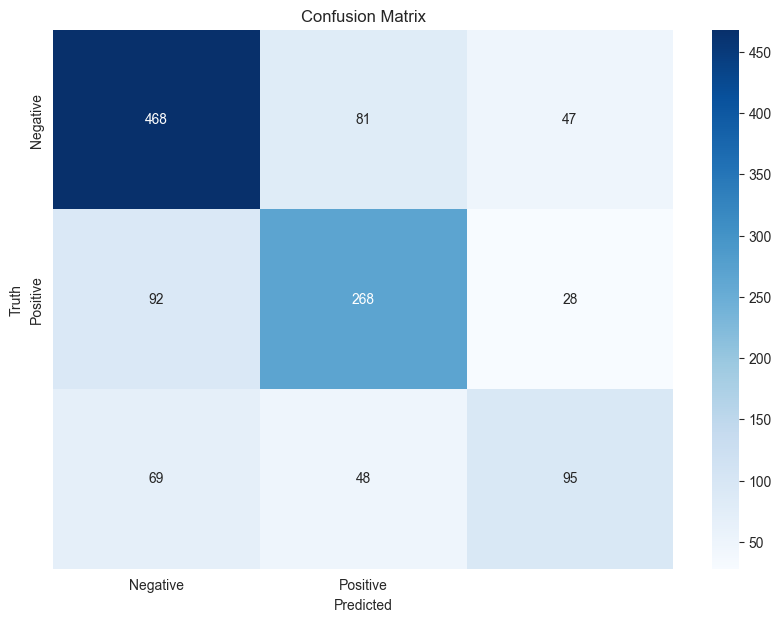

In [65]:
print(classification_report(y_test,y_pred))
show_confusion_matrix(cm)